# Chirp simulation

June 18, 2018

Reference: 
- [Sound Synthesis with Numpy](https://dzone.com/articles/sound-synthesis-numpy)
- [Decoding LoRa, a Wireless
Network for the Internet of Things](https://www.rsaconference.com/writable/presentations/file_upload/hta-f01-decoding-lora-a-wireless-network-for-the-internet-of-things_copy1.pdf)
- [LoRa Reverse Engineering and AES ](https://fosdem.org/2018/schedule/event/sdr_lora_aes/attachments/slides/2357/export/events/attachments/sdr_lora_aes/slides/2357/LoRa_AES_Security_SDR_FOSDEM_2018.pdf)

In [1]:
%matplotlib inline

from numpy import linspace, sin, cos, exp, pi, int16, abs, real, imag, random, sqrt
from scipy.io.wavfile import write
from scipy.signal import spectrogram
from scipy.fftpack import fft, ifft, fftfreq, fftshift
import matplotlib.pyplot as plt
import peakutils
import pandas
from IPython.display import display, Audio

In [2]:
SAMPLING_RATE = 8000  # Hz
SAMPLES = 2048
TIME_FRAME = SAMPLES/SAMPLING_RATE # Time frame in sec
AMPLITUDE = 20000 # 16bit PCM max amplitude

# Chirp sweep range in Hz
F1 = 220  # A3 tone
F2 = 440  # A4 tone

WAVE_FILE="./ChirpTone.wav"

## Chirp tone synthesis

In [3]:
# Complex version of chirp tone generator
def chirp(amp=AMPLITUDE, updown="up", length=TIME_FRAME, phase=0, rot=1.0):
    t = linspace(0, length, int(length * SAMPLING_RATE))
    delta = float(F2 - F1)/float(length)
    if (updown == "up"):
        freq = F1 + delta * t
    elif (updown == "down"):
        freq = F2 - delta * t
    arg = (2 * pi * freq * t) * rot + phase
    return exp(1j * arg) * amp

# White noise generator
def white_noise(amp=AMPLITUDE, length=TIME_FRAME):
    a = random.random(int(length * SAMPLING_RATE)) * 2 * amp - amp
    b = random.random(int(length * SAMPLING_RATE)) * 2 * amp - amp
    return a + 1j * b

In [4]:
# Plot FFT frequency domain
def plot_fft(wave, thres=0.95):
    plt.figure(figsize=(8, 4), dpi=80)
    y = fftshift(fft(wave))
    freq = fftshift(fftfreq(len(y), 1/SAMPLING_RATE))

    a = abs(y)
    plt.plot(freq, a)
    plt.xlabel("Frequency(Hz)")
    plt.ylabel("Magnitude")
    plt.title("Frequency domain")

    freq = fftshift(fftfreq(len(y), 1/SAMPLING_RATE))
    print("Frequencies at peaks: {} Hz".format(freq[peakutils.indexes(a, thres=thres)]))

# Plot spectrogram
def plot_spectrogram(wave, nperseg, band):
    plt.figure(figsize=(8, 3), dpi=80)
    f, t, Sxx = spectrogram(real(wave), nperseg=nperseg, fs=SAMPLING_RATE)
    plt.pcolormesh(t, f[:band], Sxx[:band])
    plt.ylabel('Frequency [Hz]')
    plt.xlabel('Time [sec]')
    plt.title("Spectrogram")

# Plot wave
def plot_wave(wave, real_only=False):
    t = linspace(0, len(wave)/SAMPLING_RATE, len(wave))
    plt.figure(figsize=(8, 4), dpi=80)
    if real_only:
        plt.plot(t, real(wave))
    else:
        plt.plot(t, real(wave))
        plt.plot(t, imag(wave))
    plt.ylabel('Amplitude')
    plt.xlabel('Time [sec]')
    plt.title("Time domain")

# Playback chirp signal as tone
def play(wave):
    write(WAVE_FILE, SAMPLING_RATE, real(wave).astype(int16))
    display(Audio('./' + WAVE_FILE))

## Up chirp

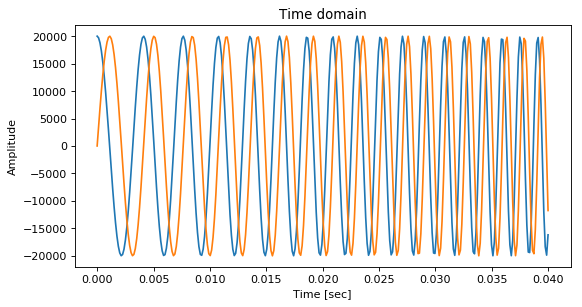

In [5]:
plot_wave(chirp(length=0.04), real_only=False)

In [6]:
play(chirp(length=2.0))

Frequencies at peaks: [-647.5 -232.5  232.5  647.5] Hz


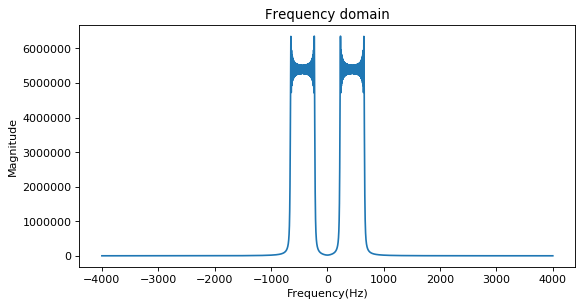

In [7]:
plot_fft(real(chirp(length=2.0)))

Frequencies at peaks: [232.5 647.5] Hz


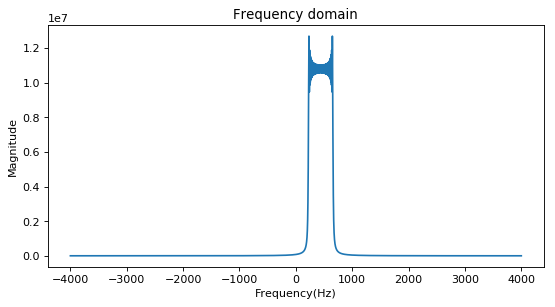

In [8]:
plot_fft(chirp(length=2.0))

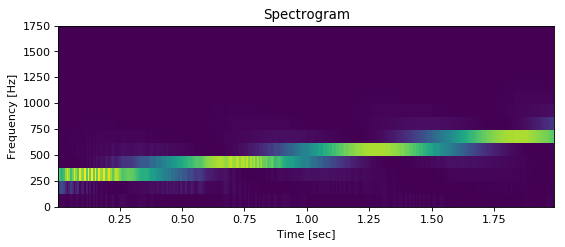

In [9]:
plot_spectrogram(chirp(length=2.0), nperseg=64, band=15)

## Up chirp * up chirp conjugate

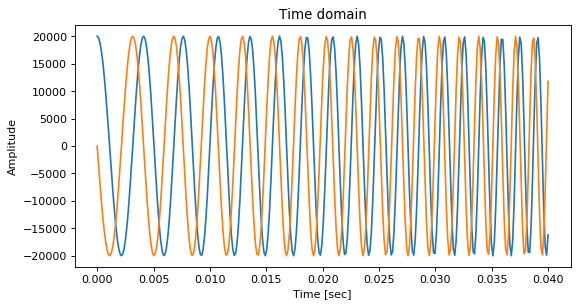

In [10]:
plot_wave(chirp(length=0.04).conjugate(), real_only=False)

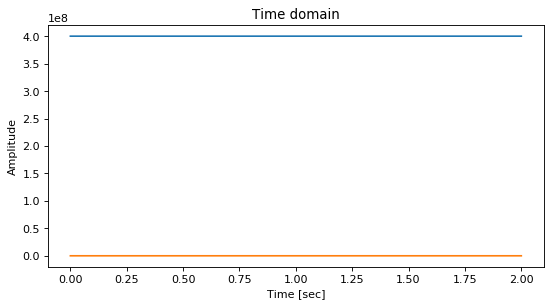

In [11]:
plot_wave(chirp(length=2.0) * chirp(length=2.0).conjugate())

In [12]:
play(chirp(length=2.0) * chirp(length=2.0).conjugate())

Frequencies at peaks: [0.] Hz


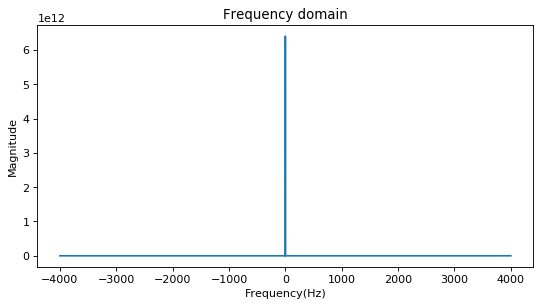

In [13]:
plot_fft(chirp(length=2.0) * chirp(length=2.0).conjugate())

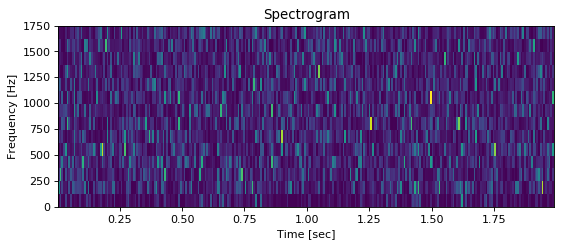

In [14]:
plot_spectrogram(chirp(length=2.0) * chirp(length=2.0).conjugate(), nperseg=64, band=15)

## Up chirp * Down chirp

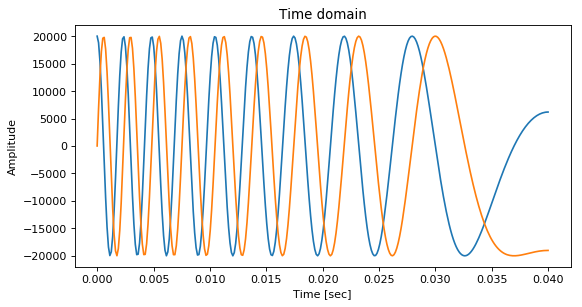

In [15]:
plot_wave(chirp(length=0.04, updown="down"), real_only=False)

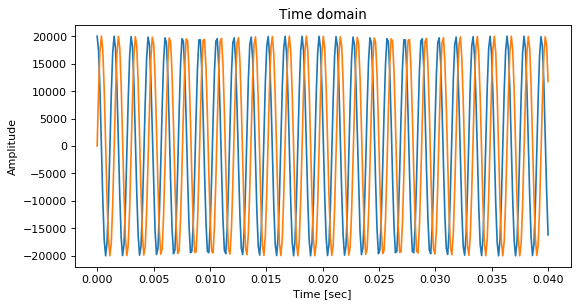

In [16]:
plot_wave(chirp(length=0.04, amp=sqrt(AMPLITUDE)) * chirp(length=0.04, amp=sqrt(AMPLITUDE), updown="down"))

In [17]:
play(chirp(length=2.0, amp=sqrt(AMPLITUDE)) * chirp(length=2.0, amp=sqrt(AMPLITUDE), updown="down"))

Frequencies at peaks: [660.] Hz


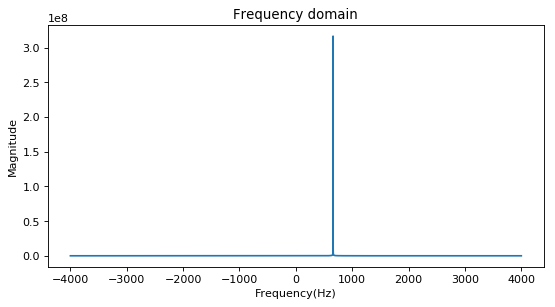

In [18]:
plot_fft(chirp(length=2.0, amp=sqrt(AMPLITUDE)) * chirp(length=2.0, amp=sqrt(AMPLITUDE), updown="down"))

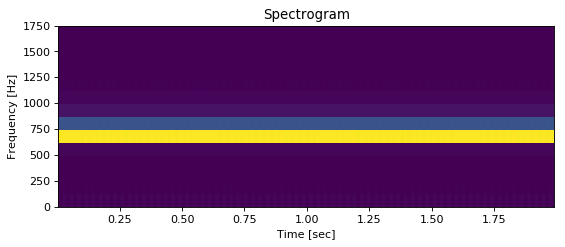

In [19]:
plot_spectrogram(chirp(length=2.0, amp=sqrt(AMPLITUDE)) * chirp(length=2.0, amp=sqrt(AMPLITUDE), updown="down"), nperseg=64, band=15)

## Chirp signal under noise level

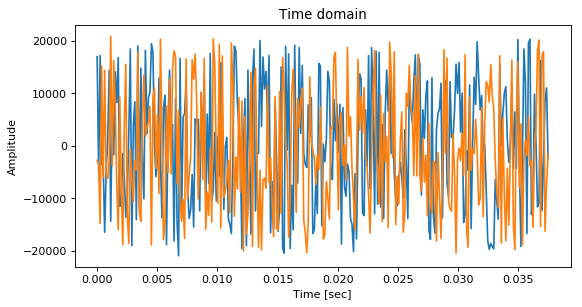

In [20]:
# Chirp signal under noise level (amplitude = 1000, noise amplitude = 20000)
plot_wave((chirp(length=2.0, amp=1000) + white_noise(length=2.0))[0:300], real_only=False)

Frequencies at peaks: [-2802.5   105. ] Hz


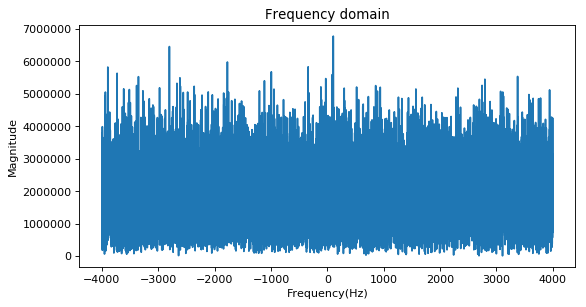

In [21]:
# Chirp signal under noise level (amplitude = 1000, noise amplitude = 20000)
plot_fft((chirp(length=2.0, amp=1000) + white_noise(length=2.0)))

Frequencies at peaks: [0.] Hz


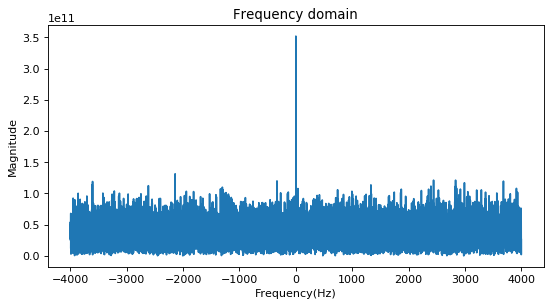

In [22]:
# Chirp signal under noise level (amplitude = 1000, noise amplitude = 20000)
plot_fft((chirp(length=2.0, amp=1000) + white_noise(length=2.0)) * chirp(length=2.0).conjugate())

Frequencies at peaks: [660.] Hz


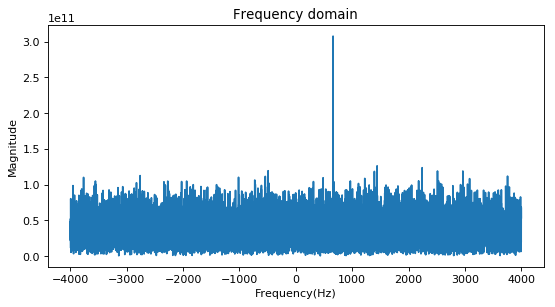

In [23]:
# Chirp signal under noise level (amplitude = 1000, noise amplitude = 20000)
plot_fft((chirp(length=2.0, amp=1000) + white_noise(length=2.0)) * chirp(length=2.0, updown="down"))

Frequencies at peaks: [660.] Hz


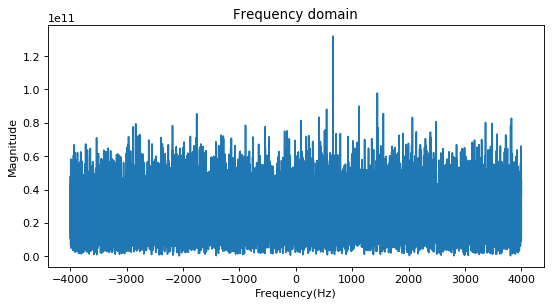

In [31]:
# Real Chirp signal under noise level (amplitude = 1000, noise amplitude = 20000)
plot_fft((real(chirp(length=2.0, amp=1000) + white_noise(length=2.0))) * chirp(length=2.0, updown="down"))

Frequencies at peaks: [660.] Hz


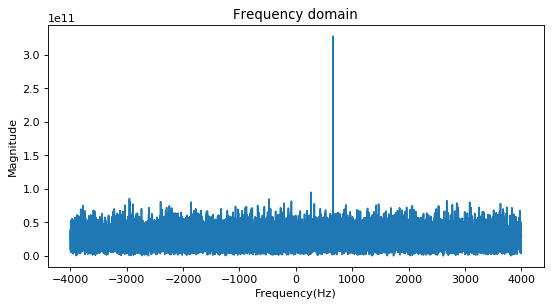

In [35]:
# Real Chirp signal under noise level (amplitude = 2000, noise amplitude = 20000)
plot_fft((real(chirp(length=2.0, amp=2000) + white_noise(length=2.0))) * chirp(length=2.0, updown="down"))

## Chirp compression

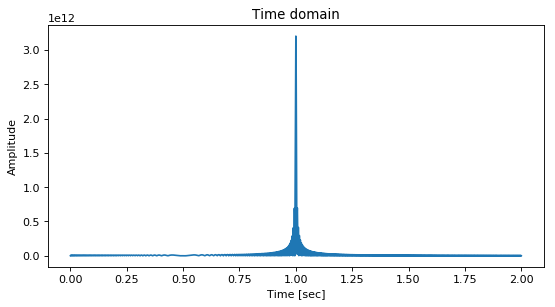

In [24]:
plot_wave(abs(ifft(fft(chirp(length=2.0)) * fft(chirp(length=2.0, updown="down")))), real_only=True)

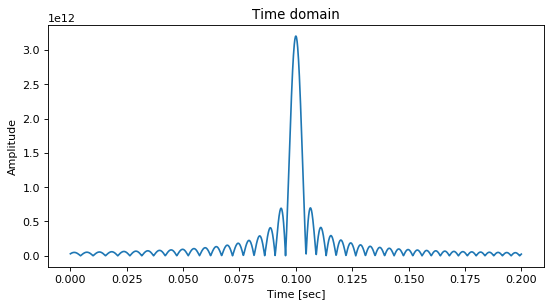

In [25]:
plot_wave(abs(ifft(fft(chirp(length=2.0)) * fft(chirp(length=2.0, updown="down"))))[7200:8800], real_only=True)

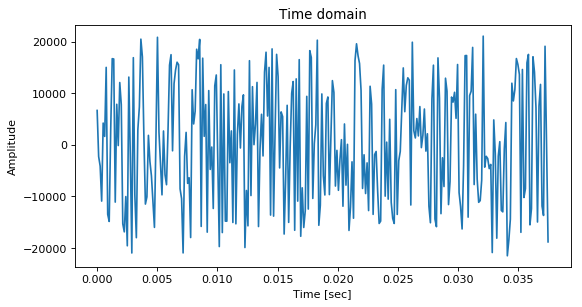

In [40]:
# Real Chirp signal under noise level (amplitude = 2000, noise amplitude = 20000)
plot_wave(real(chirp(length=2.0, amp=2000) + white_noise(length=2.0))[0:300], real_only=True)

Frequencies at peaks: [-3231.  -3207.  -2682.  -1485.5  1485.5  2682.   3207.   3231. ] Hz


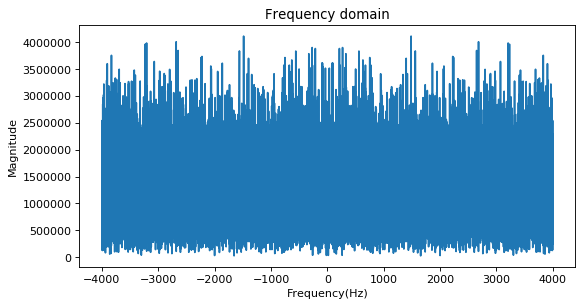

In [41]:
# Real Chirp signal under noise level (amplitude = 2000, noise amplitude = 20000)
plot_fft(real(chirp(length=2.0, amp=2000) + white_noise(length=2.0)))

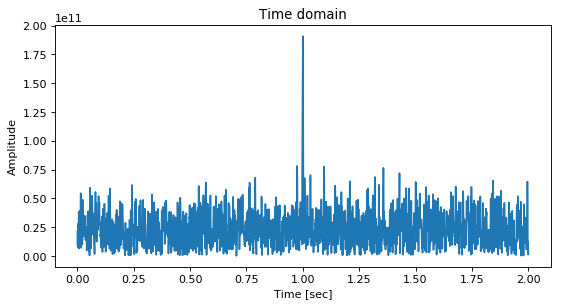

In [34]:
# Real Chirp signal under noise level (amplitude = 2000, noise amplitude = 20000)
plot_wave(abs(ifft(fft(real(chirp(length=2.0, amp=2000) + white_noise(length=2.0))) * fft(chirp(length=2.0, updown="down")))), real_only=True)